In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn as imbl

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from impyute.imputation.cs import fast_knn

In [3]:
csv=pd.read_csv(r'./train_Df64byy.csv')
csv.set_index('ID',inplace=True)
csv.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
ID,,,,,,,,,,,,,
1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [4]:
def replace_binary(data):
    binary_cols=['Accomodation_Type','Reco_Insurance_Type',
            'Is_Spouse']
    for col in binary_cols:
        data.replace(data[col].unique(),[0,1],inplace=True)
    return data

In [5]:
def rep_city(data):
    city_code=data['City_Code'].unique()
    rep_by=[i for i in range(1,len(city_code)+1)]
    data['City_Code'].replace(city_code,rep_by,inplace=True)
    return data

In [6]:
def rep_mode(data,fit=True,**mode_vals):
    cols=['Health Indicator','Holding_Policy_Type','Holding_Policy_Duration']
    if fit:
        mode_vals={}
        for i in cols:
            mode_value=data[i].mode()
            mode_vals[i]=mode_value
            data[i].fillna(mode_value[0],inplace=True)
        return data,mode_vals
    else:
        for i in cols:
            mode_value=mode_vals[i]
            data[i].fillna(mode_value[0],inplace=True)
        return data

In [7]:
def rep_health(data):
    health=csv['Health Indicator'].unique()
    bar=[x for x in range(len(health),0,-1)]
    csv['Health Indicator'].replace(health,bar,inplace=True)
    return data

In [8]:
def drop_cols(data):
    x=csv.drop(['Upper_Age','Lower_Age','Region_Code','Is_Spouse',
                'Response'],axis=1)
    y=csv.Response
    return x,y

In [9]:
csv['Holding_Policy_Duration'].replace('14+',15,inplace=True)

In [10]:
csv['Holding_Policy_Duration'].value_counts()

1.0     4499
15      4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64

In [11]:
duration=csv['Holding_Policy_Duration'].unique()
weight=[x for x in range(len(duration),0,-1)]
csv['Holding_Policy_Duration'].replace(duration,weight,inplace=True)

In [12]:
csv=replace_binary(csv)
csv=rep_city(csv)
csv,mode=rep_mode(csv)
csv=rep_health(csv)

In [13]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50882 entries, 1 to 50882
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  int64  
 1   Region_Code              50882 non-null  int64  
 2   Accomodation_Type        50882 non-null  int64  
 3   Reco_Insurance_Type      50882 non-null  int64  
 4   Upper_Age                50882 non-null  int64  
 5   Lower_Age                50882 non-null  int64  
 6   Is_Spouse                50882 non-null  int64  
 7   Health Indicator         50882 non-null  int64  
 8   Holding_Policy_Duration  50882 non-null  int64  
 9   Holding_Policy_Type      50882 non-null  float64
 10  Reco_Policy_Cat          50882 non-null  int64  
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 5.4 MB


In [14]:
x,y=drop_cols(csv)

In [15]:
x.columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

In [16]:
oversample=imbl.over_sampling.SMOTE()

In [17]:
x_over,y_over=oversample.fit_resample(x,y)

In [18]:
y_over.value_counts()

0    38673
1    38673
Name: Response, dtype: int64

<AxesSubplot:>

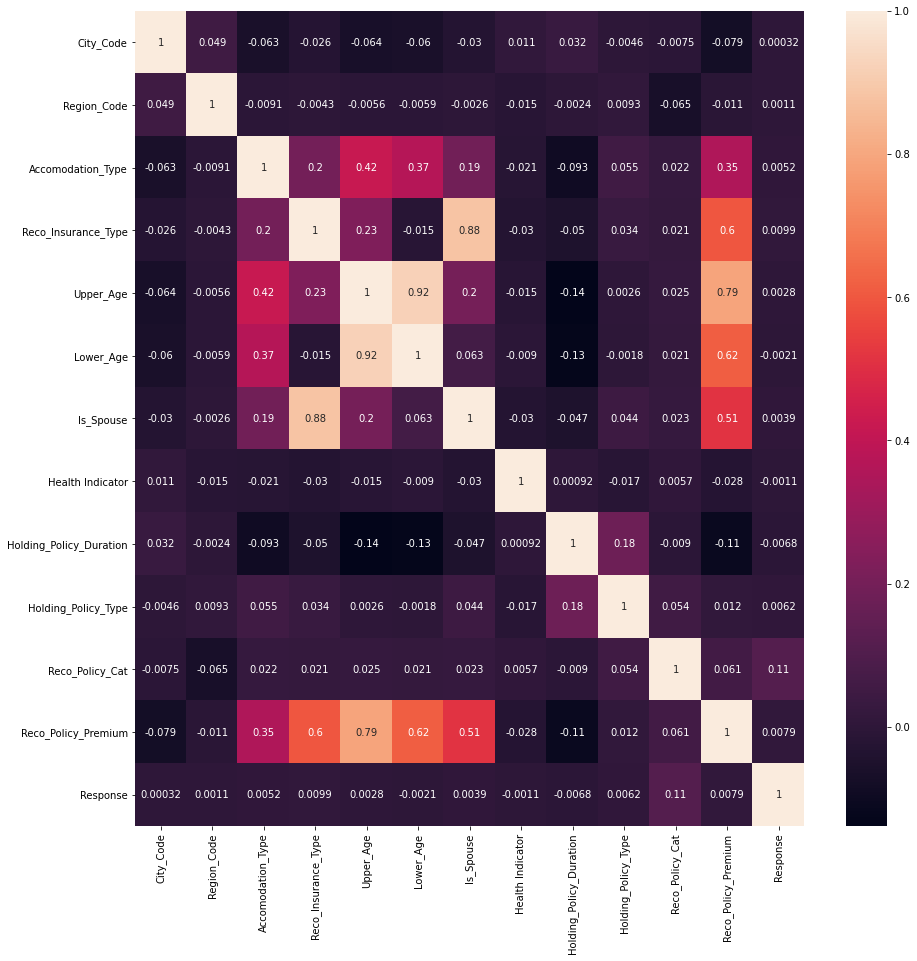

In [19]:
plt.figure(figsize=(15,15))
sns.heatmap(csv.corr(),annot=True)

/home/vbelwal7/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Reco_Policy_Premium'>

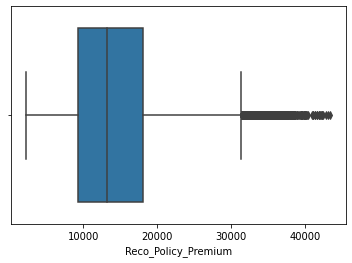

In [20]:
sns.boxplot(csv['Reco_Policy_Premium'])

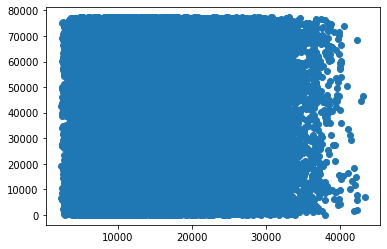

In [67]:
plt.scatter(x_over['Reco_Policy_Premium'],x_over.index)

In [22]:
x_over.columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

In [23]:
    one_h_cols=['City_Code','Accomodation_Type','Reco_Insurance_Type','Reco_Policy_Cat']
    ord_cols=['Health Indicator','Holding_Policy_Duration']
    reg_cols=['Reco_Policy_Premium']
    full_pip=ColumnTransformer([
            ('Categorical_columns',OneHotEncoder(sparse=False),one_h_cols),
            ('Ordinal_columns',OrdinalEncoder(),ord_cols),
            ('Regression_columns',StandardScaler(),reg_cols)
        ])
    x_data=full_pip.fit_transform(x_over)


In [24]:
y=y_over.values

In [25]:
y.shape

(77346,)

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y,
                                              shuffle=True,
                                              test_size=0.15)

In [27]:
x_train.shape,y_train.shape

((65744, 65), (65744,))

In [28]:
x_test.shape,y_test.shape

((11602, 65), (11602,))

In [29]:
model=LogisticRegression()

In [30]:
model.fit(x_train,y_train)

/home/vbelwal7/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
roc_auc_score(y_test,model.predict(x_test))

0.6548342308286674

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rm4=RandomForestClassifier(n_estimators=200,n_jobs=-1)

In [34]:
rm4.fit(x_train,y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [35]:
roc_auc_score(y_test,rm4.predict(x_test))

0.6927270484885226

In [36]:
import tensorflow as tf

In [37]:
n_inputs=x_train[0].shape[0]

In [38]:
nn_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_inputs,input_shape=(n_inputs,)
                          ,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(2,activation='sigmoid')
])

In [39]:
nn_model.compile(tf.keras.optimizers.Adam(lr=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [40]:
nn_model.fit(x_train,y_train,epochs=30,
            validation_data=(x_test,y_test))

Epoch 1/30
2055/2055 [==============================] - 4s 2ms/step - loss: 0.6604 - accuracy: 0.6114 - val_loss: 0.6110 - val_accuracy: 0.6444
Epoch 2/30
2055/2055 [==============================] - 3s 1ms/step - loss: 0.6041 - accuracy: 0.6627 - val_loss: 0.5951 - val_accuracy: 0.6705
Epoch 3/30
2055/2055 [==============================] - 3s 1ms/step - loss: 0.5934 - accuracy: 0.6727 - val_loss: 0.5902 - val_accuracy: 0.6764
Epoch 4/30
2055/2055 [==============================] - 3s 2ms/step - loss: 0.5873 - accuracy: 0.6784 - val_loss: 0.5869 - val_accuracy: 0.6805
Epoch 5/30
2055/2055 [==============================] - 3s 2ms/step - loss: 0.5758 - accuracy: 0.6906 - val_loss: 0.5883 - val_accuracy: 0.6784
Epoch 6/30
2055/2055 [==============================] - 3s 1ms/step - loss: 0.5712 - accuracy: 0.6946 - val_loss: 0.5733 - val_accuracy: 0.6952
Epoch 7/30
2055/2055 [==============================] - 3s 1ms/step - loss: 0.5628 - accuracy: 0.7011 - val_loss: 0.5805 - val_accuracy:

In [41]:
roc_auc_score(y_test,nn_model.predict_classes(x_test))

/home/vbelwal7/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.6897806188557233

In [42]:
test_csv=pd.read_csv(r'./test_YCcRUnU.csv').set_index('ID')

In [43]:
test_csv.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
ID,,,,,,,,,,,,
50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [44]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21805 entries, 50883 to 72687
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                21805 non-null  object 
 1   Region_Code              21805 non-null  int64  
 2   Accomodation_Type        21805 non-null  object 
 3   Reco_Insurance_Type      21805 non-null  object 
 4   Upper_Age                21805 non-null  int64  
 5   Lower_Age                21805 non-null  int64  
 6   Is_Spouse                21805 non-null  object 
 7   Health Indicator         16778 non-null  object 
 8   Holding_Policy_Duration  13202 non-null  object 
 9   Holding_Policy_Type      13202 non-null  float64
 10  Reco_Policy_Cat          21805 non-null  int64  
 11  Reco_Policy_Premium      21805 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 2.2+ MB


In [45]:
mode['Health Indicator'][0]

'X1'

In [46]:
test_csv=replace_binary(test_csv)
test_csv=rep_city(test_csv)

In [47]:
cols=['Health Indicator','Holding_Policy_Type']
for i in cols:
    mode_value=mode[i]
    test_csv[i].fillna(mode_value[0],inplace=True)

In [48]:
test_csv=rep_health(test_csv)

In [49]:
test_csv.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
ID,,,,,,,,,,,,
50883,1,156,0,0,30,30,0,X1,6.0,3.0,5,11934.0
50884,2,7,0,1,69,68,1,X1,3.0,3.0,18,32204.8
50885,1,564,1,0,28,28,0,X3,2.0,4.0,17,9240.0
50886,3,1177,1,0,23,23,0,X3,3.0,3.0,18,9086.0
50887,1,951,0,0,75,75,0,X3,NaN,3.0,5,22534.0


In [50]:
test_csv.drop(['Region_Code','Upper_Age','Lower_Age','Is_Spouse'],axis=1,inplace=True)

In [51]:
test_csv.columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

In [52]:
x_over.columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium'],
      dtype='object')

In [53]:
health=test_csv['Health Indicator'].unique()
bar=[x for x in range(len(health),0,-1)]
test_csv['Health Indicator'].replace(health,bar,inplace=True)

In [54]:
test_csv['Holding_Policy_Duration'].replace('14+',15,inplace=True)
test_csv['Holding_Policy_Duration'].replace(duration,weight,inplace=True)

In [55]:
x_trials=full_pip.transform(test_csv)

In [56]:
results=nn_model.predict(x_trials)

In [57]:
x=pd.DataFrame(data=[test_csv.index,results[:,1]]).T

In [58]:
x.head()

,0,1
0,50883.0,0.660680
1,50884.0,0.519556
2,50885.0,0.522680
3,50886.0,0.580730
4,50887.0,0.598243


In [59]:
x.rename(columns={0:'ID',
                  1:'Response'},inplace=True)

In [60]:
x.set_index('ID',inplace=True)

In [61]:
x.head()

,Response
ID,
50883.0,0.660680
50884.0,0.519556
50885.0,0.522680
50886.0,0.580730
50887.0,0.598243


In [62]:
x.to_csv(r'./Results.csv',sep=',')

In [63]:
n=pd.read_csv('Results.csv')

In [64]:
n.head()

,ID,Response
0,50883.0,0.660680
1,50884.0,0.519556
2,50885.0,0.522680
3,50886.0,0.580730
4,50887.0,0.598243


In [65]:
csv['Holding_Policy_Duration'].mode()

0    15
dtype: int64